### Цель проекта
Проанализировать данные с производства, чтобы построить модель для предсказания конечного состава сплава стали. 

По данным, полученным после первого измерения химического состава стали и шлака, и параметрам процесса плавления позволит прогнозировать химический состав шлака в конце этапа легирования стали.


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import random

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_table('data/steel_alloying.csv', sep=';', index_col=0, decimal=',')
data.head()

,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,0.456460,...,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,0.359285,...,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,0.331665,...,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,0.377945,...,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,0.389875,...,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN


In [3]:
# размер датасета
data.shape

(7041, 84)

In [4]:
# data.info()

In [5]:
# data['ПРОФИЛЬ'].value_counts() 
# Значения данного столбца скорее относятся к форме сплава, чем его сотставу. 

In [6]:
# Удаляемя не информативные признаки 
data.drop(['nplv', 'DT', 'ПРОФИЛЬ'], axis=1, inplace=True)

In [7]:
data['МАРКА'].value_counts(dropna=False)

Э76ХФ     4953
Э90ХАФ    1384
Э73Ф       227
Э76Ф        86
Ш2.2        59
Э76         56
900А        54
R350HT      54
Э76ХАФ      50
R260        35
G2HH        34
Ш2Л         31
НХ           7
09Г2С        4
С345         3
С255         2
Ст3сп        1
С355         1
Name: МАРКА, dtype: int64

Выборка по маркам сталей не сбалонсированная, сформируем три класса сталей Э76ХФ, Э90ХАФ и другие - объединение остальных классов.

In [8]:
remain_mark = ['Э76ХФ', 'Э90ХАФ']        
        
data['МАРКА']  = data['МАРКА'].apply(lambda x: x if x in remain_mark else 'другие')

In [9]:
data['МАРКА'].value_counts()

Э76ХФ     4953
Э90ХАФ    1384
другие     704
Name: МАРКА, dtype: int64

## Переменные времени

In [10]:
data.iloc[:, 1:5].describe()

,t вып-обр,t обработка,t под током,t продувка
count,6444.000000,6440.000000,6440.000000,6444.000000
mean,26.492241,46.194099,21.010523,46.063051
std,14.842045,9.878727,4.758272,9.625492
min,-1.000000,4.350000,2.816667,4.350000
25%,14.000000,42.350000,18.033333,42.216667
50%,25.000000,44.683333,20.500000,44.550000
75%,37.000000,47.550000,23.300000,47.516667
max,98.000000,294.083333,67.583333,251.000000


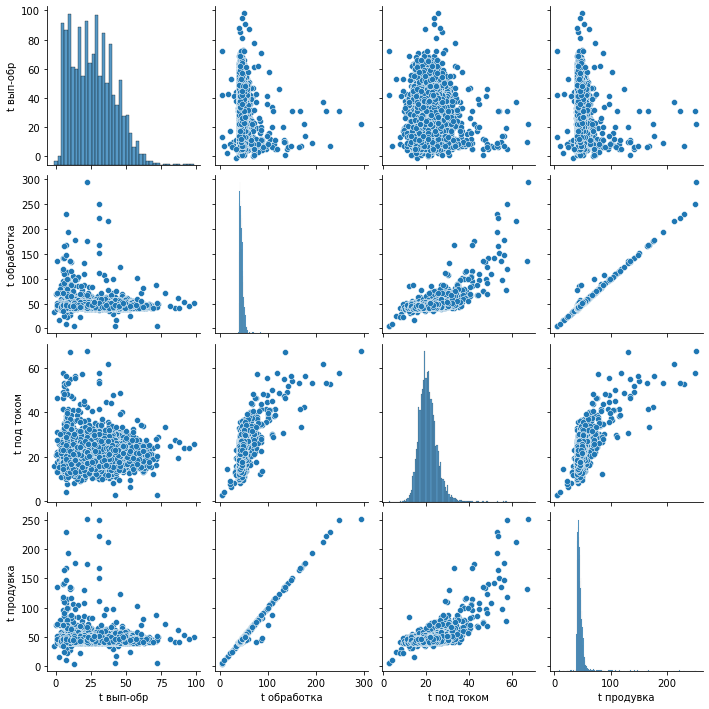

In [11]:
sns.pairplot(data.iloc[:, 1:5])

##  Удаление полупустых строчек и столбцев

### Строки

In [12]:
null_values = pd.DataFrame({'кол-во пропуск' :data.iloc[:, :].isna().sum()})
null_values['per'] = (null_values.iloc[:, 0] * 100 / len(data)).apply(lambda x: round(x, 2))
null_values.value_counts().head(5) # количесвто колонок, в которых одинаковое кол-во пропусков

кол-во пропуск  per  
597             8.48     37
598             8.49      4
601             8.54      4
2299            32.65     4
5652            80.27     2
dtype: int64

In [13]:
# Проверяем, что в 37 колонках, в которых отстутвует 597 значений, пропуски относятся к одним и тем же строкам.
empty_columns = data[null_values[null_values.per == 8.48].index].T.isna().sum() 
(empty_columns == 37).sum()

597

In [14]:
data[null_values[null_values.per == 8.48].index].columns
# в этих строках отутсвуют основные переменные, по которым мы анализуем наши данные (химшлак последний CaO, FeO, MnO, R)
# значит можем эти строки удалять

Index(['t вып-обр', 't продувка', 'произв жидкая сталь',
       'произв количество обработок', 'произв  количество плавок',
       'произв количество плавок (цел)', 'химсталь первый Al_1',
       'химсталь первый C_1', 'химсталь первый Cr_1', 'химсталь первый Cu_1',
       'химсталь первый Mn_1', 'химсталь первый Ni_1', 'химсталь первый P_1',
       'химсталь первый S_1', 'химсталь первый Si_1', 'химсталь первый Ti_1',
       'химсталь первый V_1', 'химсталь последний Al', 'химсталь последний C',
       'химсталь последний Cr', 'химсталь последний Cu',
       'химсталь последний Mn', 'химсталь последний Mo',
       'химсталь последний Ni', 'химсталь последний P', 'химсталь последний S',
       'химсталь последний Si', 'химсталь последний Ti',
       'химсталь последний V', 'химшлак первый CaO_1', 'химшлак первый FeO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MnO',
       'химшлак последний R'],
  

In [15]:
data.drop(empty_columns[empty_columns == 37].index, axis=0, inplace=True)
data.shape

(6444, 81)

### Столбцы

In [16]:
def df_null_values(df):
    null_values = pd.DataFrame({'кол-во пропуск' :df.isna().sum()})
    null_values['per'] = (null_values.iloc[:, 0] * 100 / len(df)).apply(lambda x: round(x, 3))
    return null_values

In [17]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head(17)

,кол-во пропуск,per
ферспл FeSi-75,6439,99.922
сыпуч кокс. мелочь (сух.),6437,99.891
сыпуч кварцит,6431,99.798
ферспл FeMo,6411,99.488
ферспл Ni H1 пласт.,6362,98.727
ферспл FeV азот.,6061,94.056
расход C пров.,5720,88.765
ферспл ферванит,5427,84.218
N2 (интенс.),5055,78.445
расход газ N2,5055,78.445


In [18]:
#удалим колонки, в которых больше 70 % пропусков 
data.drop(null_values[null_values.per > 70].index, axis=1, inplace=True)
data.shape

(6444, 71)

Так же удалим строки, в которых пропущены значения целевых переменных. Для построения прогнозов они нам не нужны. Если мы попробуем восстановить эти пропуски, то возможны смещения конечных значений.

In [19]:
null_target = ['химшлак первый SiO2_1', 'химшлак последний SiO2',
       'химшлак первый Al2O3_1', 'химшлак последний Al2O3'] 
data.dropna(subset=null_target, axis=0, inplace=True)

# Восстановление пропущенных значений

In [20]:
def brief_summary(series):
#     series.hist()
    plt.show();
    print(series.name, '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(series.mean(), 3),\
                                                                         round(series.std(), 3),\
                                                                         series.median()))

def description(df, columns):
    for name in columns:
        print(name, '\nПропущенных значений:', df[name].isna().sum(),\
              '(', round(df[name].isna().sum() * 100 / len(df[name]), 2)  ,'%)',
             '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(df[name].mean(), 3),\
                                                                         round(df[name].std(), 3),\
                                                                         df[name].median()),\
              '\nУникальных значений: {}'.format(df[name].value_counts(dropna=False).count()), '\n')
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(221)
        plt.hist(df[name])
        plt.grid()
        plt.subplot(222)
        sns.boxplot(y=df[name])
        plt.show()

In [21]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head()

,кол-во пропуск,per
сыпуч известь РП,978,20.624
ПСН гр.,948,19.992
сыпуч шпат плав.,467,9.848
ферспл фх850А,418,8.815
чист расход Cr,418,8.815


In [22]:
data.shape

(4742, 71)

## сыпуч известь РП

У данной переменной 26 % пропущенных значений. Попробуем восстановить их через внутриклассовые медианы значений

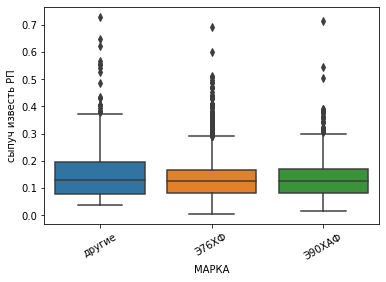

In [23]:
ax = sns.boxplot(data=data, y='сыпуч известь РП' , x='МАРКА')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);


Распределние не симметричное, с длинным правым хвостом, попробуем прологарифмировать эти значения, чтобы получить более симметричное распределение.

In [24]:
data['ln сыпуч известь РП'] = np.log(data['сыпуч известь РП'])

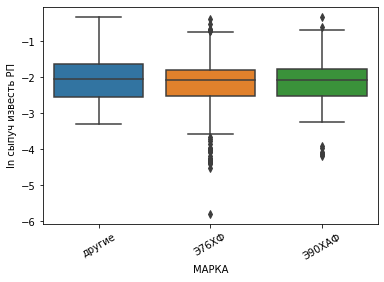

In [25]:
ax = sns.boxplot(data=data, y='ln сыпуч известь РП', x='МАРКА')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [26]:
name = 'ln сыпуч известь РП' 
grouped = data[['МАРКА', name]].groupby('МАРКА')
CaO_ln = grouped[name].transform(lambda x: x.fillna(x.median()))

Посмотрим как изменится распределение "сыпуч известь РП" после подстановки пропущенных значений

In [27]:
brief_summary(np.exp(CaO_ln))

ln сыпуч известь РП 
Медиана: 0.12600000000000003, Среднее значение: 0.135, Ср.откл:0.071


In [28]:
brief_summary(data['сыпуч известь РП'])

сыпуч известь РП 
Медиана: 0.126, Среднее значение: 0.137, Ср.откл:0.079


In [29]:
data['сыпуч известь РП'] = np.exp(CaO_ln)

In [30]:
# data.isna().sum().sort_values(ascending=False)

## ПСН гр. 

In [31]:
data[['ПСН гр.', 'эл. энергия (интенс.)']].corr()

,ПСН гр.,эл. энергия (интенс.)
ПСН гр.,1.000000,0.478797
эл. энергия (интенс.),0.478797,1.000000


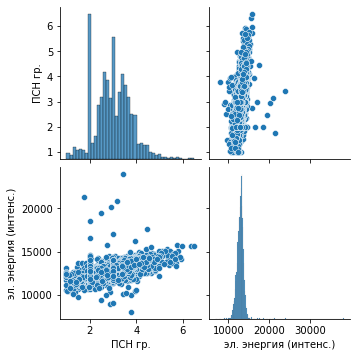

In [32]:
sns.pairplot(data[['ПСН гр.', 'эл. энергия (интенс.)']]);

ПСН гр. хорошо коррелирует с "эл. энергия (интенс.)"

Удалим "ПСН гр." из датасета, так как он не очень информативен

In [33]:
data.drop('ПСН гр.', axis=1, inplace=True)

In [34]:
null_values = df_null_values(data)
data_with_nan = null_values[null_values.per != 0].sort_values('per', ascending = False)
data_with_nan.iloc[4:, :].head()

,кол-во пропуск,per
чист расход V,175,3.690
ферспл CaC2,174,3.669
ферспл FeV-80,174,3.669
химсталь последний Ca,166,3.501
сыпуч кокс. мелочь КМ1,81,1.708


### Переменные: чист расход Cr, сыпуч  шпат плав., ферспл  фх850А

In [35]:
num_line_by_marka = data['МАРКА'].value_counts().sort_index()

In [36]:
Cr_nan = pd.DataFrame({'marka': data['МАРКА'], 'Cr': data['чист расход Cr'].isna(),'fx850': data['ферспл  фх850А'].isna(),
                      'сыпуч  шпат плав.': data[ 'сыпуч  шпат плав.'].isna() }).groupby('marka')[['Cr','fx850', 'сыпуч  шпат плав.']].sum().sort_index()
Cr_nan
check_with_Cr = pd.DataFrame({'Cr_nan': Cr_nan.Cr, 'fx850_nan' : Cr_nan.fx850, 'num_line_in_makr' : num_line_by_marka, 'сыпуч  шпат плав.': Cr_nan['сыпуч  шпат плав.'] })
check_with_Cr

,Cr_nan,fx850_nan,num_line_in_makr,сыпуч шпат плав.
marka,,,,
Э76ХФ,10,10,3264,285
Э90ХАФ,3,3,996,91
другие,405,405,482,91


In [37]:
brief_summary(data['сыпуч  шпат плав.'])

сыпуч  шпат плав. 
Медиана: 0.046, Среднее значение: 0.052, Ср.откл:0.022


In [38]:
data['сыпуч  шпат плав.'].fillna(data['сыпуч  шпат плав.'].median(), inplace=True)

In [39]:
brief_summary(data['сыпуч  шпат плав.'])

сыпуч  шпат плав. 
Медиана: 0.046, Среднее значение: 0.051, Ср.откл:0.021


In [40]:
 data[['МАРКА', 'чист расход Cr']].groupby('МАРКА').agg(['mean', 'median', 'std'])

чист расход Cr                    
                 mean    median       std
МАРКА                                    
Э76ХФ        0.127701  0.128592  0.026878
Э90ХАФ       0.094454  0.094522  0.024237
другие       0.114541  0.114124  0.048321

In [41]:
brief_summary(data['чист расход Cr'])
grouped = data[['МАРКА', 'чист расход Cr']].groupby('МАРКА')
data['чист расход Cr'] = grouped['чист расход Cr'].transform(lambda x: x.fillna(x.median()))
brief_summary(data['чист расход Cr'])

чист расход Cr 
Медиана: 0.12108599999999999, Среднее значение: 0.12, Ср.откл:0.03
чист расход Cr 
Медиана: 0.117874, Среднее значение: 0.119, Ср.откл:0.029


In [42]:
 data[['МАРКА', 'ферспл  фх850А']].groupby('МАРКА').agg(['mean', 'median', 'std'])

ферспл  фх850А                 
                 mean median       std
МАРКА                                 
Э76ХФ        0.225754  0.227  0.047746
Э90ХАФ       0.167070  0.168  0.043634
другие       0.201052  0.201  0.084726

In [43]:
brief_summary(data['ферспл  фх850А'])
grouped = data[['МАРКА', 'ферспл  фх850А']].groupby('МАРКА')
data['ферспл  фх850А'] = grouped['ферспл  фх850А'].transform(lambda x: x.fillna(x.median()))
brief_summary(data['ферспл  фх850А'])

ферспл  фх850А 
Медиана: 0.214, Среднее значение: 0.212, Ср.откл:0.054
ферспл  фх850А 
Медиана: 0.20800000000000002, Среднее значение: 0.211, Ср.откл:0.051


## Остальные пропущенные значения заполним медианами

In [44]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head(26)

,кол-во пропуск,per
ln сыпуч известь РП,978,20.624
чист расход V,175,3.690
ферспл FeV-80,174,3.669
ферспл CaC2,174,3.669
химсталь последний Ca,166,3.501
сыпуч кокс. мелочь КМ1,81,1.708
ферспл SiMn18,35,0.738
ферспл Mn5Si65Al0.5,29,0.612
сыпуч кокс пыль УСТК,10,0.211
чист расход Mn,8,0.169


In [45]:
# удалим одно значение, для которого у наc нет значения целевой переменной
data.dropna(axis=0, subset=['химшлак первый MgO_1', 'химшлак последний MgO'], inplace=True)

In [46]:
df = data.isna().sum()
df = df[df != 0]
df
# data[df.index].hist(figsize=(20,20));

t обработка                  3
t под током                  2
чист расход C                6
чист расход Mn               8
чист расход Si               8
чист расход V              175
температура первая           6
температура последняя        6
Ar (интенс.)                 7
эл. энергия (интенс.)        2
расход газ Ar                7
сыпуч кокс пыль УСТК        10
сыпуч  кокс. мелочь КМ1     81
ферспл CaC2                174
ферспл  FeV-80             174
ферспл  Mn5Si65Al0.5        29
ферспл SiMn18               35
эл. энергия                  2
химсталь первый Mo_1         1
химсталь первый N_1          1
химсталь последний Ca      166
химсталь последний N         2
ln сыпуч известь РП        978
dtype: int64

In [47]:
# заполним пропуски этих переменных медианой всего признака, так как отсвует меньше 5 % данных для них
# и распредления либо симметричны, либо с выраженным пиком
data[df.index] = data[df.index].apply(lambda x : x.fillna(x.median()))

### Удаление неинформативных признаков

In [48]:
# Нормирование и вариативность признаков
scaler = StandardScaler()
scaler.fit(data.iloc[:,1:])
feature_selection = scaler.transform(data.iloc[:,1:])
# data.iloc[:, 1: ] = feature_selection
std_df = pd.DataFrame(feature_selection, columns=data.iloc[:, 1:].columns).std()
std_df.sort_values(ascending=True)

произв количество плавок (цел)    0.000000
произв  количество плавок         0.000000
химсталь последний V              1.000105
произв количество обработок       1.000105
химсталь последний Ca             1.000105
                                    ...   
химсталь последний Al             1.000105
химсталь первый Al_1              1.000105
химсталь последний Ti             1.000105
химсталь первый N_1               1.000105
ферспл CaC2                       1.000105
Length: 70, dtype: float64

In [49]:
data.drop(['произв количество плавок (цел)', 'произв  количество плавок'], inplace=True, axis=1)

In [50]:
data.shape

(4741, 69)

In [51]:
data.head()

,МАРКА,t вып-обр,t обработка,t под током,t продувка,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,...,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2,ln сыпуч известь РП
463,другие,43.0,44.166667,21.683333,44.166667,0.481645,0.196138,0.201185,0.251281,0.039825,...,1.8,26.8,5.7,56.2,0.4,7.8,0.07,2.2,26.0,-0.970219
589,Э76ХФ,18.0,42.016667,20.016667,41.850000,0.339285,0.075060,0.066049,0.068946,0.038742,...,2.3,25.6,3.2,54.8,0.8,6.1,0.09,2.4,23.2,-2.071473
818,Э90ХАФ,7.0,41.033333,17.383333,41.033333,0.523411,0.108273,0.200457,0.148846,0.095573,...,2.4,24.5,4.6,61.8,0.5,6.1,0.08,2.4,26.1,-2.071473
1029,другие,9.0,43.850000,18.950000,43.850000,0.433960,0.114124,0.175658,0.089606,0.041396,...,2.4,20.4,4.7,54.8,0.6,11.6,0.16,2.1,26.1,-2.071473
1036,другие,7.0,46.716667,19.216667,46.716667,0.548870,0.114124,0.199137,0.087354,0.041748,...,2.3,23.8,5.4,51.9,0.5,10.3,0.15,2.1,24.2,-2.071473


## Выбросы

In [52]:
# удаление выбросов
out_forest = IsolationForest(n_estimators=100, max_features=68, n_jobs=-1, contamination=0.1)
out_forest.fit(data.iloc[:, 1:])
outlier_predicted = out_forest.predict(data.iloc[:, 1:])

data = data.loc[outlier_predicted == 1, :].copy()
data.shape
(outlier_predicted != 1).sum()  ## сколько строк удалили

474

### Поиск взаимосвязей между целевыми переменными

In [53]:
# description(ready_df.iloc[:, 1:-2], ready_df.columns[1:-2])

In [54]:
columns = ['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']
# sns.pairplot(data[columns])
plt.show();

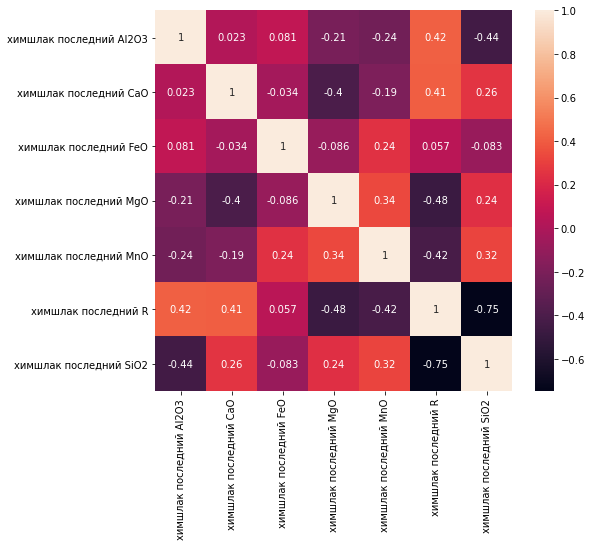

In [55]:
corr_for_target = data[columns].corr()
plt.figure(figsize=(8,7))
sns.heatmap(corr_for_target, annot=True);

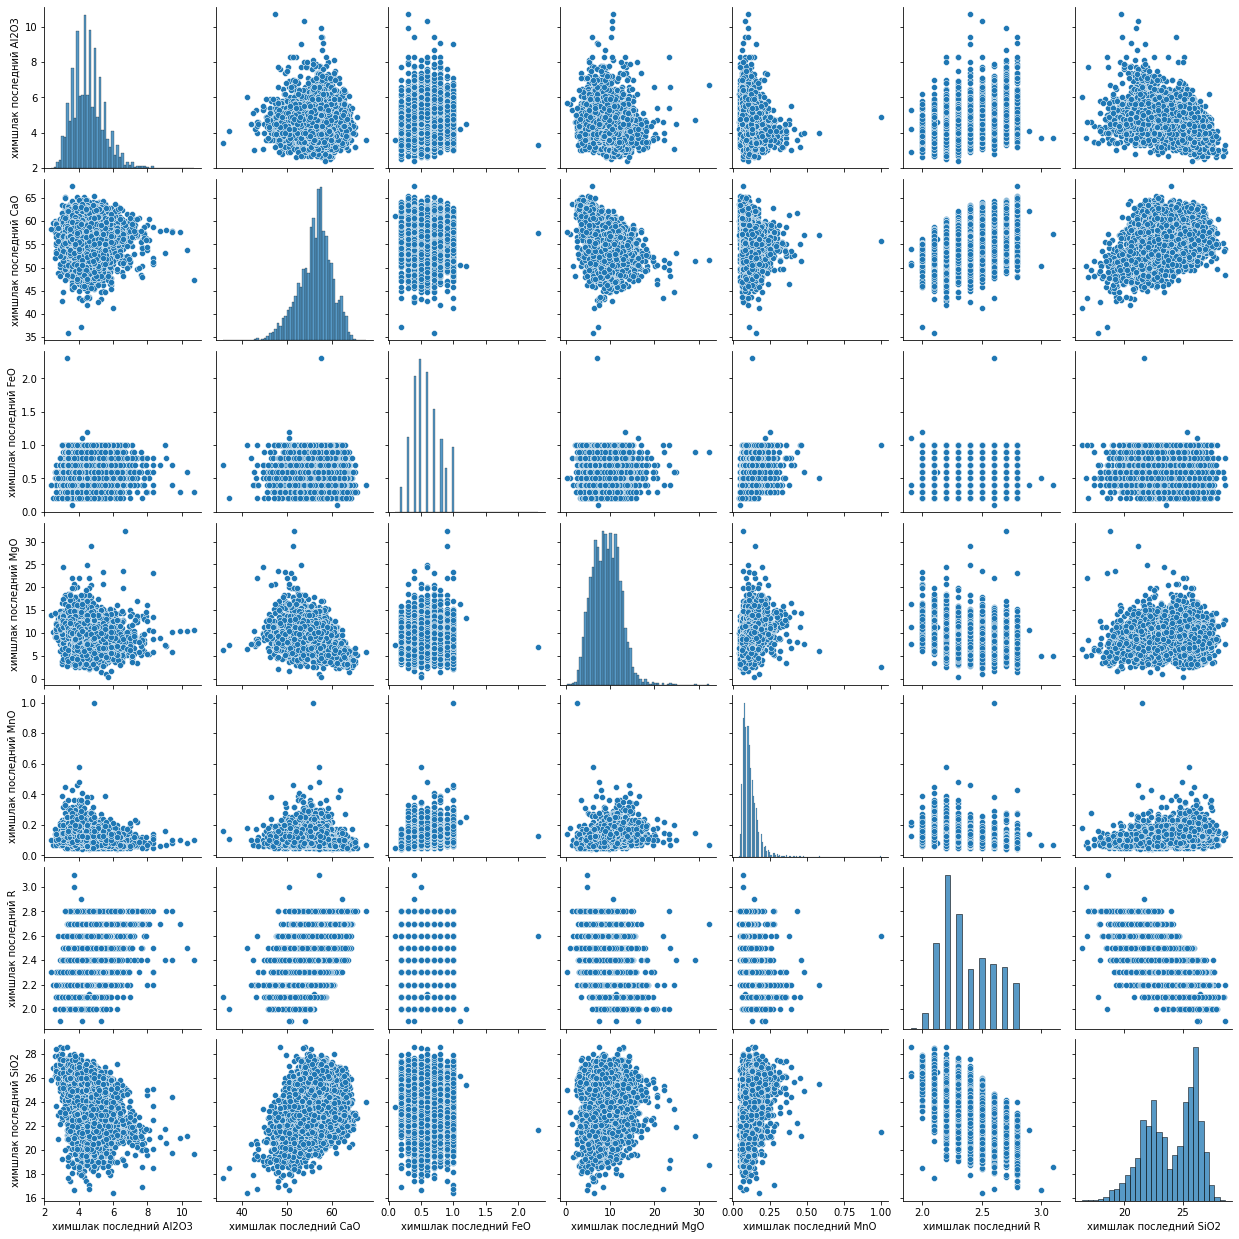

In [56]:
sns.pairplot(data[columns])
plt.show();

In [57]:
# Проверим, что коэффиценты корреляции по модулю больше 0.15 статистически значимы
real_corr = []
for k, i in enumerate(columns):
    for j in columns[k + 1:]:
        df = data[[i, j]].dropna()
        corr = pearsonr(df[i].to_numpy(), df[j])
        if  (corr[1] > 0.05) and (corr[0] > 0.15) :  
            print(i , j, corr)

In [58]:
target_name = []
target_corr = []
corr = []
for name in columns:
    df = np.abs(corr_for_target[name]).sort_values(ascending=False)
    target_name.append(name)
    target_corr.append(df.index[1])
    corr.append(round(corr_for_target.loc[name, df.index[1]], 3))
target_corr_df = pd.DataFrame({'target' : target_name, 'corr_target': target_corr, 'corr' : corr})
target_corr_df

,target,corr_target,corr
0,химшлак последний Al2O3,химшлак последний SiO2,-0.441
1,химшлак последний CaO,химшлак последний R,0.411
2,химшлак последний FeO,химшлак последний MnO,0.243
3,химшлак последний MgO,химшлак последний R,-0.478
4,химшлак последний MnO,химшлак последний R,-0.418
5,химшлак последний R,химшлак последний SiO2,-0.747
6,химшлак последний SiO2,химшлак последний R,-0.747


Из таблицы выше видно, что 4 целевые переменные больше всего коррелируют с химшлаком R, однако R имеет дискретное распределение.

In [59]:
data.shape

(4267, 69)

In [60]:
# сохраним обработанный датасет
data.to_csv('data/data_for_next_step.csv')

## Отбор признаков

In [61]:
target_columns = ['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']

target = data[target_columns]
X = data.drop(['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2'], axis=1)

scaler = StandardScaler()
scaler.fit(X.iloc[:, 1:-2])
feature_selection = scaler.transform(X.iloc[:,1:-2])
X.iloc[:, 1:-2] = feature_selection

In [62]:
target.to_csv('data/targets')

In [63]:
X = pd.get_dummies(X, drop_first=True)
X.shape

(4267, 63)

In [64]:
def cross_val_check_for_each(y_df, X_df, model):
    for name in y_df.columns:    
        y = y_df[name] 
        print(name, 'r2:', round(cross_val_score(model, X_df, y_df, cv=5).mean(),4))


In [65]:
# По результат линейной регрессии определяем, 
# какой порог коэффицента корреляция выбрать для удаления линейно зависимых признаков

for C in np.linspace(0.5, 1, 6):
    temp_df = abs(X.iloc[:, :-3].corr()) > C
    maybe_remove_col = []
    for k, i in enumerate(temp_df.columns.to_list()):
        for j in temp_df.columns.to_list()[k + 1 :]:
            if temp_df.loc[j, i] :
    #             print(i, j)
                maybe_remove_col.append(i)
    maybe_remove_col = set(maybe_remove_col)
    print('\nПри пороговом знаяении корреляции между признаками', C, 'удалим', len(maybe_remove_col), 'признаков\n')
    
    print('\nЛинейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2')
    cross_val_check_for_each(target, X.drop(maybe_remove_col, axis=1), LinearRegression())


При пороговом знаяении корреляции между признаками 0.5 удалим 28 признаков


Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2
химшлак последний Al2O3 r2: 0.0718
химшлак последний CaO r2: 0.0718
химшлак последний FeO r2: 0.0718
химшлак последний MgO r2: 0.0718
химшлак последний MnO r2: 0.0718
химшлак последний R r2: 0.0718
химшлак последний SiO2 r2: 0.0718

При пороговом знаяении корреляции между признаками 0.6 удалим 23 признаков


Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2
химшлак последний Al2O3 r2: 0.1733
химшлак последний CaO r2: 0.1733
химшлак последний FeO r2: 0.1733
химшлак последний MgO r2: 0.1733
химшлак последний MnO r2: 0.1733
химшлак последний R r2: 0.1733
химшлак последний SiO2 r2: 0.1733

При пороговом знаяении корреляции между признаками 0.7 удалим 19 признаков


Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и S

In [66]:
features_corr = X.iloc[:, :-3].corr()
temp_df = abs(features_corr) > 0.9
maybe_remove_col = []
for k, i in enumerate(temp_df.columns.to_list()):
    for j in temp_df.columns.to_list()[k + 1 :]:
        if temp_df.loc[j, i] :
#             print(i, j, round(features_corr.loc[j, i], 2))
            maybe_remove_col.append(i)
maybe_remove_col = set(maybe_remove_col)
print('Выбрали пороговое значение корреляции между признаками:', 0.9, '\nудалим', len(maybe_remove_col), 'признаков')
print(maybe_remove_col)

print('\nЛинейная регрессия по всем признакам, которые остались')
cross_val_check_for_each(target, X.drop(maybe_remove_col, axis=1), LinearRegression())

Выбрали пороговое значение корреляции между признаками: 0.9 
удалим 14 признаков
{'ферспл  FeV-80', 'химсталь первый Mo_1', 'чист расход Mn', 'химсталь первый Cr_1', 't под током', 'химсталь первый P_1', 'химсталь последний C', 'чист расход V', 'химсталь первый Cu_1', 'чист расход Cr', 'чист расход Si', 'чист расход C', 't обработка', 'химсталь первый Ni_1'}

Линейная регрессия по всем признакам, которые остались
химшлак последний Al2O3 r2: 0.1919
химшлак последний CaO r2: 0.1919
химшлак последний FeO r2: 0.1919
химшлак последний MgO r2: 0.1919
химшлак последний MnO r2: 0.1919
химшлак последний R r2: 0.1919
химшлак последний SiO2 r2: 0.1919


In [67]:
X = data.drop(target_columns, axis=1).copy()
X_no_LD = X.drop(maybe_remove_col, axis=1)

In [68]:
X.to_csv('data/features_data.csv')
X_no_LD.to_csv('data/features_data_without_ld.csv')

### Гипотезы

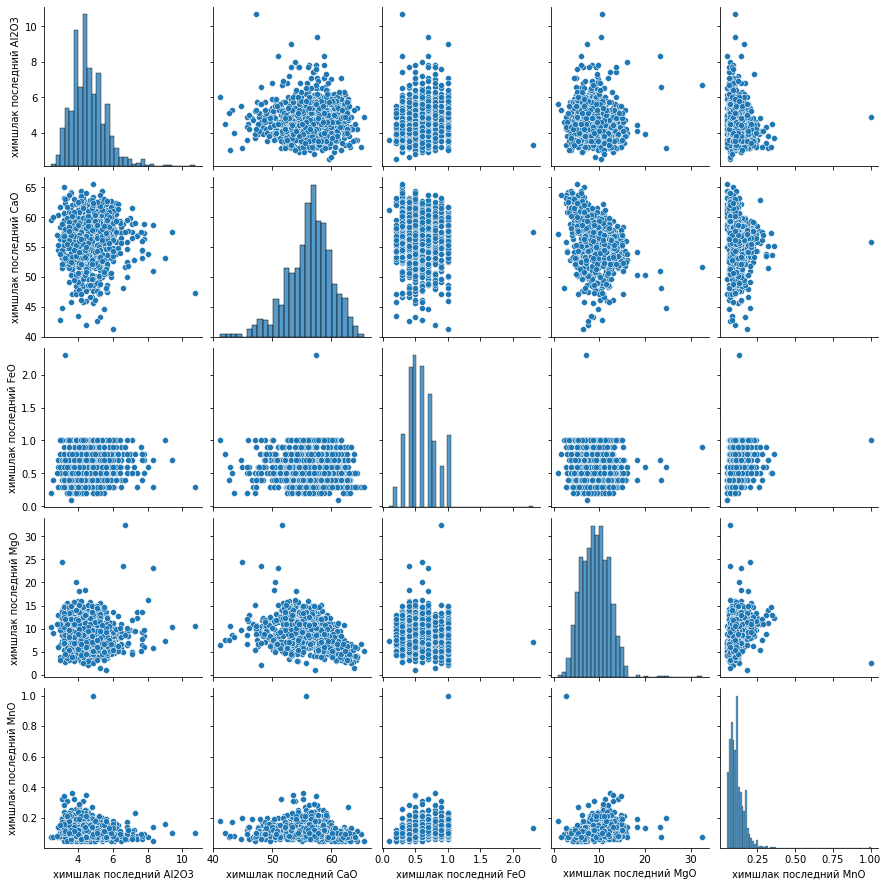

In [69]:
# Посмотрим на зависимости между целевыми переменными графически. Данных около 5000,
# поэтому для более ясной картины я выберу 1000 случайны 1000 строк.
random_samples = random.sample(target.index.to_list(), 1000)
sns.pairplot(target.loc[random_samples, target.columns[:-2]]);

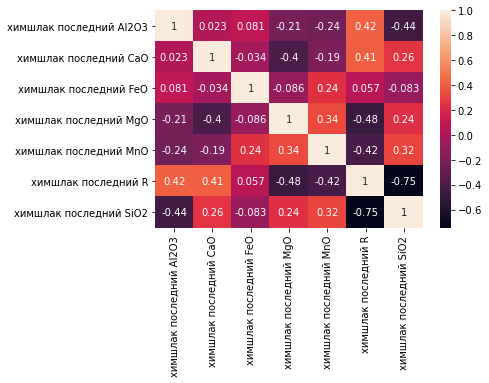

In [70]:
sns.heatmap(target.corr(), annot=True);

Гипотеза: целевые переменные можно восстановить с помощью других целевых переменных:

Al2O3 <- R (corr = 0.44) или SiO2 <- (corr = 0.41)

SiO2 <- R (corr = -0.75)

CaO <- MgO <- R // CaO <- MgO (corr = -0.41), MgO <- R (corr = -0.48)

*CaO <- R // (corr = -0.41)

FeO <- MnO <- R //  FeO <- MnO (corr = 0.25), MnO <- R (corr = -0.41)

По графикам распредлений видно, что R и FeO имеют дискретное распредление, возможно предсказания через них будут не очень точными. Дополнительно для восстановления других переменных через них надо использовать переменные c непрерывным рапределением.

Графичеcки я вижу среди непрерывных распределений линейную зависимость между CaO и MgO, CaO и SiO2

Гипотеза: Для FeO и R использовать классификацию, а не регрессию.

In [71]:
# target['химшлак последний FeO'].value_counts()

In [72]:
1702 / 7041 

0.24172702741087915

In [73]:
data.shape

(4267, 69)

### Отчет
7041

1. Из 18 марок сталей сформировали 3 класса: Э76ХФ, Э90ХАФ и Другие - объединение остальных классов, чтобы сделать менее не сбалансированную выборку

2. Удалили неинформативные признаки и признаки с более 70 % пропусками (16 колонок): 

'nplv', 'DT', 'ПРОФИЛЬ' - не имеют отношение к задаче

'произв количество плавок (цел)', 'произв  количество плавок' - нулевая дисперсия

'ПСН гр.' - линейно зависимые с переменными энергии 

'N2 (интенс.)', 'расход газ  N2', 'расход C пров.', 'сыпуч кварцит', 'сыпуч  кокс. мелочь (сух.)', 'ферспл FeMo', 'ферспл FeSi-75', 'ферспл FeV азот.', 'ферспл  Ni H1 пласт.', 'ферспл  ферванит' - переменные, в которых отсутсвуют более 70 % данных

3. Мы удалили 2774 строк (40 % начальных данных). В них входили строки, в которых остуствовали значения 37 признаков, включая целевые переменны. Еще один элемент не имел значения по химпшлаку MnO, 1702 (24 %) строки были удалены, так как в них не было значений целевых переменных.


4. 'Cыпуч известь РП' и 'ПСН гр.' не было 25 % данных. 'ферспл фх850А, чист расход Cr, 'сыпуч шпат плав.' не было 8 % данных.	 Восстановили их с помощью внутриклассовой медианы по маркам. Остальные восстановила медианой признака, так как пропусков было меньше 5 % и их распределения были или симметричны, или с ярко выраженным пиком.


6. Выбросы удалила с помощью IsolationForest с параметром удаления 10 % данных.

В итоге осталось 4267 строк и 68 столбцов.

7 - целевых переменных

1 - категориальный признак 'МАРКА'


Для последующего анализа рассматривается два датасета, в одном из них остались линейно зависимые признаки с коэффицентом корреляции больше 0.9, из другого такие признаки были удалены (15 признаков).

Сформирована гипотеза, что некоторые целевые признаки можно предсказать по другим. Графически наблюдается линейная зависимоть между CaO и MgO. 

По графикам распредлений видно, что R и FeO имеют дискретное распредление, возможно для предсказания значений этих переменных стоит использовать классификацию.

Несмотря на дискретное рапределение химшлака R, эта переменная хорошо коррелируют с Al2O3 (corr = -0.75) и остальными, кроме FeO.